# Image Classification Using ConvNets

We will implement a Convolutional Neural Net from scratch to perform image classification. Many proven implementations of this ML model already exist and are available through free libraries such as tensorflow, pytorch etc. However we will not rely on these and instead build our own, to improve our understanding of what really is happening inside of the black box.

### Dataset

We will be working with [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist): a dataset containing 28x28 grayscale images of clothing articles. Although having the same type of input and range of labels, Fashion-MNIST is an alternative which is more challenging and better yet: more representative of modern image recognition problems; compared to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) we all know and love.

To download the dataset:

In [28]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P data

^C


--2022-11-26 16:49:28--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.46.140
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.46.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29515 (29K) [binary/octet-stream]
Saving to: 'data/train-labels-idx1-ubyte.gz.6'

     0K .......... .......... ........                        100%  288K=0.1s

2022-11-26 16:49:29 (288 KB/s) - 'data/train-labels-idx1-ubyte.gz.6' saved [29515/29515]

--2022-11-26 16:49:29--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.46.140
Connecting to fashion-mnist.s3-website.eu-central-1.ama

After doing this, make sure to unzip the tarballs in order

### Imports

In [1]:
import matplotlib.pyplot as plt
import mnist
import numpy as np
import math
import random
import os
from functools import partial

np.random.seed(10000)

## Understanding the data

In [2]:
mndata = mnist.MNIST('data')

images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [3]:
X_train = np.array(images_train, dtype=np.float64)
X_test = np.array(images_test, dtype=np.float64)
Y_train = np.array(labels_train, dtype=np.uint8)
Y_test = np.array(labels_test, dtype=np.uint8)

In [4]:
def label_to_binary(Y, C = 10):
    '''
Let Y be an integer array of shape N such that Y[i] is the label assigned to i-th example. 
We construct a binary array of shape N times C, where C = 10, to give the same piece of information.
    '''

    result = np.zeros((len(Y),C), dtype = np.uint8)
    
    for i in range(0, len(Y)):
        result[i][Y[i]] = 1
    
    return result

Y_train_binary = label_to_binary(Y_train)
Y_test_binary = label_to_binary(Y_test)

print(Y_train_binary.shape)
print(Y_test_binary.shape)
            

(60000, 10)
(10000, 10)


In [5]:
print(X_train.shape, X_train.dtype)
print(Y_train.shape, Y_train.dtype)
print(X_test.shape)
print(Y_test.shape)

(60000, 784) float64
(60000,) uint8
(10000, 784)
(10000,)


We have 60000 training examples and 10000 testing examples. Each of these is a list of 784 numbers which represent each of the 28x28 pixels in the image. The value of the number represents how black the pixel is.

In [6]:
label_to_article_map= {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

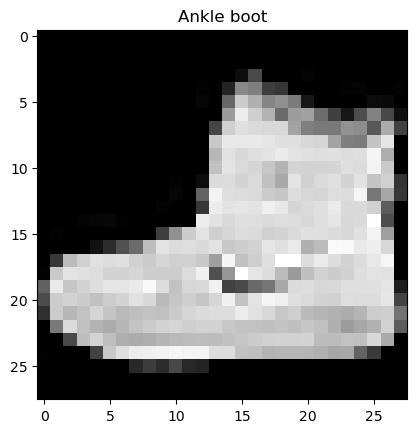

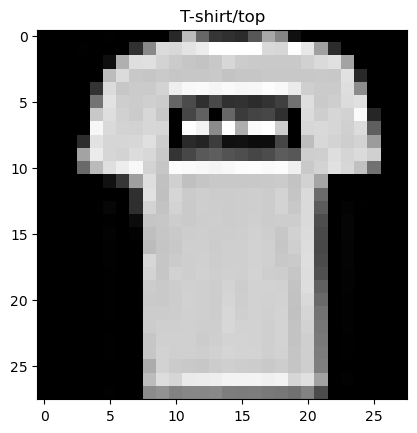

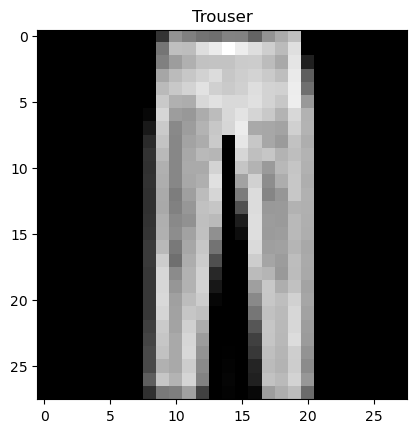

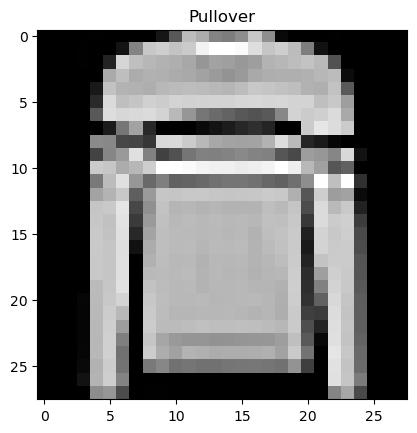

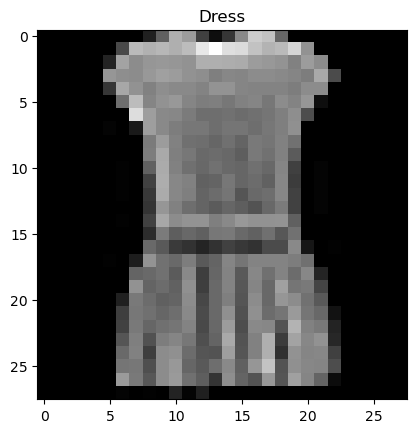

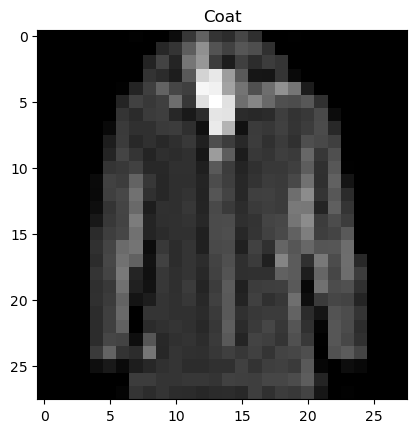

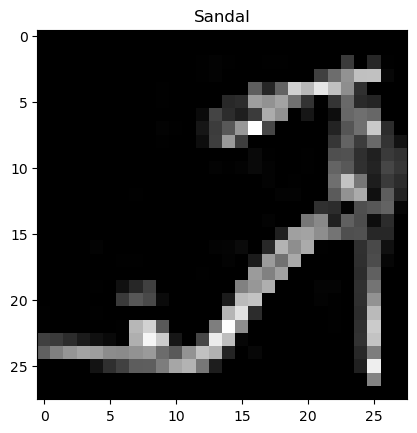

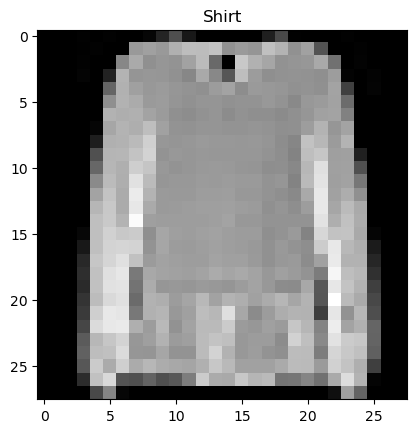

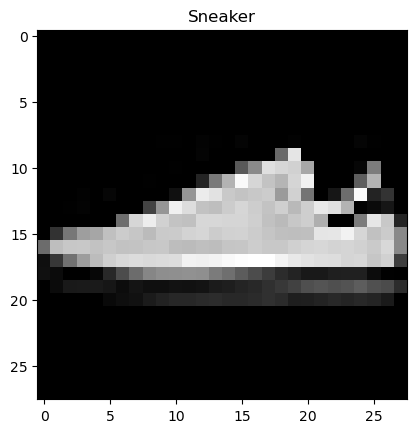

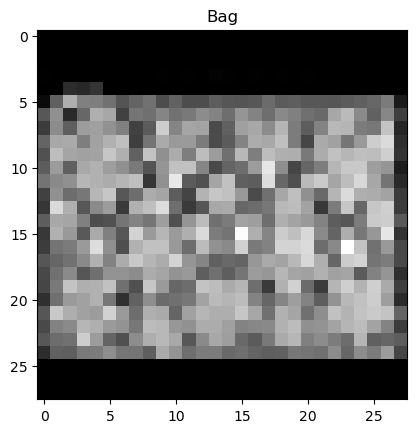

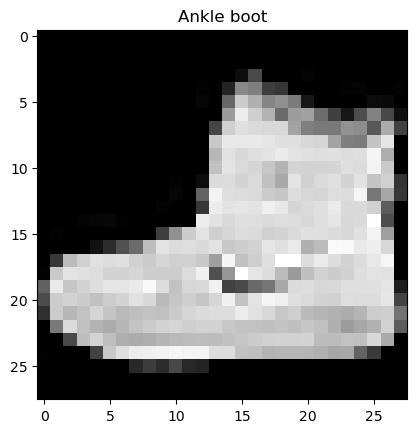

In [7]:
def display_image(index, train=True):
    if train:
        image = X_train[index]
        label = Y_train[index]
    else:
        image = X_test[index]
        label = Y_train[index]

    image = np.array(image, dtype='float')
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(f"{label_to_article_map[label]}")
    plt.show()

display_image(0)
#We display one image of each type.
for j in range(0, 10):
    for i in range(0, len(X_train)):
        if Y_train[i] == j:
            display_image(i)
            break

### Standardization

We will now standardize the data by pulling the mean to the center and adjusting the scale.

In [8]:
print(np.mean(X_test))
print(np.mean(X_train))

73.14656658163265
72.94035223214286


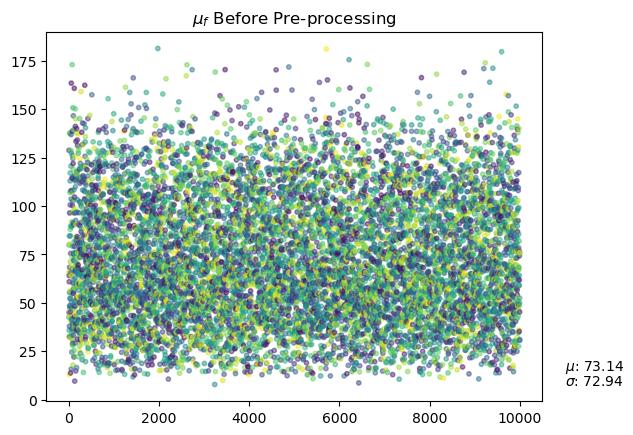

In [9]:
plt.scatter(np.arange(0, len(X_test)), list(map(np.mean, X_test)),  s=10,  alpha=.5, c = np.random.rand(X_test.shape[0]))
plt.title(r"$\mu_f$ Before Pre-processing")
plt.text(11000, 15, r"$\mu$: 73.14")
plt.text(11000, 7.5, r"$\sigma$: 72.94")
plt.show()

In [10]:
# Centering
X_train -= np.mean(X_train, axis=0)
X_test -= np.mean(X_test, axis=0)

# Normalization
X_train /= np.std(X_train, axis = 0)
X_test /= np.std(X_test, axis = 0)

In [11]:
print(np.mean(X_test))
print(np.mean(X_train))

-1.3050784942532453e-19
4.0602442043434296e-19


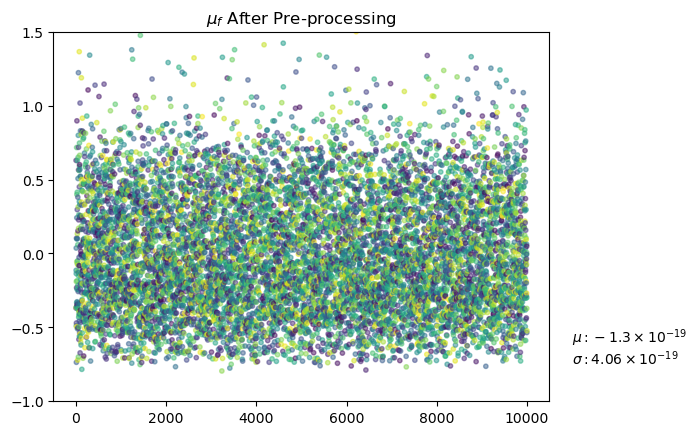

In [12]:
plt.scatter(np.arange(0, len(X_test)), list(map(np.mean, X_test)),  s=10,  alpha=.5, c = np.random.rand(X_test.shape[0]))
plt.title(r"$\mu_f$ After Pre-processing")
plt.text(11000, -.6, r"$\mu: -1.3 \times 10^{-19}$")
plt.text(11000, -.75, r"$\sigma: 4.06 \times 10^{-19}$")
plt.ylim(-1, 1.5)
plt.show()

We've effectively reduced the mean and standard deviation to approximately 0.

In [13]:
X_train_small = X_train[0:55000]
X_validation = X_train[55000:60000]
Y_train_small = label_to_binary(Y_train[0:55000])
Y_validation = Y_train[55000:60000]
Y_validation_binary = label_to_binary(Y_validation)

print(X_train_small.shape)
print(X_validation.shape)
print(Y_train_small.shape)
print(Y_validation.shape)

(55000, 784)
(5000, 784)
(55000, 10)
(5000,)


## Multi-layer Perceptron

We now code out a standard multi-layer perceptron which we will train using back propagation combined with stochastic gradient descent. The following notations are largely from chapter 20.6 of Shalev-Shwartz and Ben-David's textbook "Understanding Machine Learning: From Theory to Algorithms". We will follow them very strictly in our implementation. The code below references the structure of https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/NumpyDeepMLP.ipynb#scrollTo=WmWczKeXrTE6 .

By a <b>multi-layer perceptron</b>, we mean a edge weighted finite graph $G$ organized in the following manner:

1. There exists a positive integer $T$ such that $V(G)$ is partitioned by sets $V^0, V^1, \cdots, V^T$. These sets are called <b>layers</b>. $V^0$ is the <b>input layer</b>, $V^T$ is the <b>output layer</b>, and the rest are called the <b>hidden layers</b>. For our purpose, we assume that there is an edge between every vertex in $V^i$ and every vertex in $V^{i+1}$ for each $i \in \{0,1,\cdots, T-1\}$ and that there is no other edges. (Corollary: $G$ is bipartite.)
2. For each $t \in \{0, \cdots, T\}$, we write $k_t$ in place of $|V^t|$. We also label elements of $V^t$ from $0$ to $k_t-1$. We write $v^t_i$ for the $i$ th vertex in $V^t$ for $i \in \{0,1,\cdots, k_t-1\}$.
3. We write $W^{t}_{ij} \in \mathbb{R}$ for the weight of the edge connecting $v^t_j$ and $v^{t+1}_i$, for every $t \in \{0, \cdots, T-1\}$, every $j \in \{0, \cdots, k_t-1\}$, and every $i \in \{0, \cdots, k_{t+1}-1\}$.
4. If the input has dimension $D$ (for our case $D= 28\times 28= 784$), we assume that $k_0=D+1$. The extra dimension is prepared for bias. Suppose $x = (x_0, \cdots, x_{D-1}) \in \mathbb{R}^D$ is given as input. Define $o^{0}_{D} = 1$ and $o^0_k = x_k$ for $k \in \{0, \cdots, D-1\}$. In general, for any $t$, we write $o^t_i \in \mathbb{R}$ for the ouput of $v^t_i$.
5. Suppose the all the outputs of layer $t$ (i.e. $o^t_i$ for all $i \in \{0, \cdots, k_t-1\}$) are computed. For each $t \in \{1, \cdots, T\}$, let differentiable function $\sigma^t: \mathbb{R}^{k_t} \to \mathbb{R}^{k_t}$, which we call an <b>activation function</b>, be given. For $t \in \{0, \cdots, T-1\}$, we write $a^{t+1}_j \in \mathbb{R}$ for the input given to $v^{t+1}_j$. This quantity is defined by:

$$
a^{t+1}_j = \sum_{r=0}^{k_t-1} o^t_r W^t_{j,r}
$$

And, for our purpose, we define the output after passing the above input into the vertex by:

$$
o^{t+1}_j = \sigma^{t+1}(a^{t+1}_j)
$$

Sometimes, an activation function is defined using a function from $\mathbb{R}$ to $\mathbb{R}$. In that case, it is understood that its application is coordinate-wise. Therefore, once an input $x \in \mathbb{R}^D$ is given, the inputs/outputs for all vertices can be computed.

6. Up to now, every defined quantity is a real number. Now we start defining vectors by omitting subscripts. For each $t$, we write:

$$
o^t = (o^t_0, \cdots, o^t_{k_t-1}) \in \mathbb{R}^{k_t}
$$

And:

$$
a^t = (a^t_0, \cdots, a^t_{k_t-1}) \in \mathbb{R}^{k_t}
$$

Next, we define $W^t$ to be the $k_{t+1} \times k_t$ matrix in a manner such that the $i$ th row $j$ th column is $W^t_{i,j}$. This definition ensures that:

$$
a^{t+1} = W^{t}o^{t}
$$

The $a^t$'s and $o^t$'s will be stored using numpy arrays.

7. If the weights $W = \{W^t\}_{t=0}^{T-1}$ are determined, then every above mentionned quantity is computable after one data point $x \in \mathbb{R}^D$ is given. Now suppose we are given $N$ data points $X = \{x^n\}_{n=0}^{N-1}$. We define $A = \{A^t\}_{t=1}^{T} = \{\{a^t(x^n)\}_{n=0}^{N-1}\}_{t=1}^{T}$ and $O = \{O^t\}_{t=0}^T = \{\{o^t(x^n)\}_{n=0}^{N-1}\}_{t=0}^T$. $A$ and $O$ will be lists storing $A^t$'s and $O^t$'s. To make sure the indices correspond to the notation given here, we define $A^0$ to be the string `"UND"`. Note that since we are using stochastic gradient descent, the case $N>1$ will only be appear when predicting and by then a subscript "prediction" will be used.

8. By the <b>predict function induced by $G$</b>, we mean a function $F: \mathbb{R}^D \to \mathbb{R}^C$ such that $F(x)=o^T$ for every $x \in \mathbb{R}^D$. More explicitly, if $x = (x_0, \cdots, x_{D-1}) \in \mathbb{R}^D$, put $x' = (x_0, \cdots, x_{D-1},1) \in \mathbb{R}^{D-1}$ and set:

$$
F(x) = \sigma^T(W^{T-1}\sigma^{T-1}(W^{T-2}( \cdots \sigma^1(W^0x'))))
$$

From the above definitions, it is obvious that we have to store the following to define a multi-layer perceptron:
1. A sequence of activation functions $\Sigma = \{\sigma^t\}_{t=1}^T$. This sequence will be implemented as a list. To make sure the indices correspond to the notation given here, we define $\sigma^0$ to be the string `"UND"`.
2. A positive integer $T$ for the number of layers and a sequence $\{k_t\}_{t=0}^T$ for the number of neurons in each layer.
3. A sequence of weights $W = \{W^t\}_{t=0}^{T-1}$. This sequence will be implemented as a list.

The first two things form the architecture for our multi-layer perceptron. By <b>training</b> a multi-layer perceptron, we change the weights such that the result is optimized with respect to a given loss function. We now give details by describing the notations involved. As before, we will strictly follow them.

Let $(x,y) \in \mathbb{R}^D \times \mathbb{R}^C$ be a given training example. By a <b>global loss function</b>, we mean any function $J: \mathbb{R}^D \to [0,\infty)$. Here are some examples:

Let $y = (y_0, \cdots, y_{C-1})$ and $\hat{y} = (\hat{y}_0, \cdots, \hat{y}_{C-1})$ are two points in $\mathbb{R}^C$. Here $y$ represents the result in the training example (hence a known constant quantity) and $\hat{y}$ represents the prediction result of some multi-layer perceptron after inputting $x$ (e.g. $F(x)$ for some prediction function $F$ induced by some multi-layer preceptron with dimension $C$ output layer). The <b>cross entropy</b> cost function is given by:

$$
J(x) = \sum_{c=0}^{C-1}-y_c\ln(\hat{y}_c)
$$

The <b>min square</b> cost function is given by:

$$
J(x) = \frac{1}{2} \sum_{c=0}^{C-1} (y_c-\hat{y}_c)^2
$$

Since there are multiple cost functions, we will always specify which before we start training.

Now let a multi-layer preceptron $G$, a training example $(x,y) \in \mathbb{R}^D \times \mathbb{R}^C$, and a differentiable global loss function $J: \mathbb{R}^D \to \mathbb{R}$ be given (that is, $J(x)$ is given by one of the above with $\hat{y}=F(x)$). We consider $J$, $(x,y)$, and the architechture of $G$ to be fixed and we wish to improve the performance of $G$ by changing its weights according to $J$ and $(x,y)$. To do so, we apply stochastic gradient descent to a pool of training examples. It is thus sufficient to compute the derivative of $J$ with respect to each of the weights evaluated at $(x,y)$ and at the current weights.

For each $t \in \{0,1,\cdots,T\}$, let $l^t:\mathbb{R}^{k_t} \to \mathbb{R}$ be the global loss function of the sub-multi-layer-perceptron $v^t, \cdots, V^{T}$. We will call $l^t$'s <b>local loss functions</b>. Clearly, $l^0=J$. For each $t \in \{1, \cdots, T\}$, let $g^t: \mathbb{R}^{k_{t-1} \times k_t} \to \mathbb{R}$ be the same function as $l^t$ except that $g^t$ uses $W^{t-1}$ as its variables. In symbols, the following equation is satisfied for every $t \in \{1, \cdots, T\}$:

$$
g^t(W^{t-1}) = l^t(o^t) = l^t(\sigma^t(a^t))= l^t(\sigma^t(W^{t-1}o^{t-1}))
$$

Write $Dg^t$ for its derivative. It suffices to compute $Dg^t(W^{t-1})$, which is a linear map from $\mathbb{R}^{k_{t-1} \times k_t}$ to $\mathbb{R}$, or equivalently an $k_{t-1} \times k_t$ matrix, because we get one derivative value for each edge once we obtain $\{Dg^t(W^{t-1})\}_{t=1}^T$ and we can use this derivative to update the edge.

For simplicity, put $\delta^t = Dl^t(o^t)$ for each $t \in \{0, \cdots, T\}$. Clearly, $\delta^t$ is a linear transformation from $\mathbb{R}^{k_t}$ to $\mathbb{R}$, or equivalently an element of $\mathbb{R}^{k_t}$. The chain rule states that:

$$
Dg^t(W^{t-1}) = \delta^t \circ D \sigma^t(a^t) \circ Da^t(W^{t-1})
$$

Here we are treating $a^t = W^{t-1}o^{t-1}$ as a function of $W^{t-1}$, which is a function from $\mathbb{R}^{k_t \times k_{t-1}}$ to $\mathbb{R}^{k_t}$. The last term of the right hand side can therefore be seen as a $k_t \times k_tk_{t-1}$ matrix and can be computed explicitly. We have, in terms of matrices:

$$
Dg^t(W^{t-1}) =\delta^t (D \sigma^t(a^t))
\begin{bmatrix}
(o^{t-1})^* & 0                  & \cdots & 0 \\
0                  & (o^{t-1})^* & \cdots & 0 \\
\vdots             & \vdots             & \ddots & \vdots \\
0                  & 0                  & \cdots & (o^{t-1})^* \\
\end{bmatrix}
$$

In the code below, there will be a helper method `get_large_matrix` just for converting $o^{t-1}$ to this $k_t \times k_tk_{t-1}$ format.

We should remark that the quantity $D \sigma^t(a^t)$ is extremly easy to compute in case $\sigma^t$ is defined as the coordinate-wise application for some function from $\mathbb{R} \to \mathbb{R}$. This is because, in that case, we have:

$$
D \sigma^t(a^t) = 
\begin{bmatrix}
(D\sigma^t)(a^t_0) & 0                  & \cdots & 0 \\
0                  & (D\sigma^t)(a^t_1) & \cdots & 0 \\
\vdots             & \vdots             & \ddots & \vdots \\
0                  & 0                  & \cdots & (D\sigma^t)(a^t_{k_t-1}) \\
\end{bmatrix}
$$

Write $\delta^t = ((\delta^t)_0, \cdots, (\delta^t)_{k_t-1})$. In this special case, the above matrix multiplication has a very simple result:

$$
Dg^t(W^{t-1}) = ((\delta^t)_0(D\sigma^t)(a^t_0)(o^{t-1})^*, \cdots, (\delta^t)_{k_t-1}(D\sigma^t)(a^t_{k_t-1})(o^{t-1})^*)
$$

In the general case, the result is of course not too hard to calculate either. 

It is therefore sufficient to compute $\delta^t$. Since $J$ is given, computation of $\delta^T$ is trivial. Since:

$$
l^t(o^t) = l^{t+1}(\sigma^{t+1}(W^to^t))
$$

Differentiation gives:

$$
\delta^t = \delta^{t+1}  (D\sigma^{t+1}(a^{t+1})) W^t
$$

This completes the derivative computation. Therefore, the important quantities we must store for this training are $\Delta = \{\delta^t\}_{t=0}^T$ and $DG = \{dg^t\}_{t=1}^{T}$, where $dg^t = Dg^t(W^{t-1})$ as computed above. Both will be stored in lists. As before, we define $DG[0]$ to be the string `"UND"`. 

Finally, let us write $G$ for our multi-layer perceptron and $F$ for the prediction function induced by $G$. Since we are performing a classification task, we will always use the softmax function for $\sigma^T$. Therefore, every entry of $F(x)$ is positive. The use of cross entropy cost function (which is evaluated on $F(x)$ as mentioned above) is thus legitimate. Since the output $F(x)$ is usually not in $0$'s and $1$'s, we code out an additional function for making the final decision. This function is not a part of the multi-layer perceptron.

Let $f: \mathbb{R}^m \to \mathbb{R}^n$ be a function differentiable at $a \in \mathbb{R}^m$. Recall that its <b>total derivative at $a$</b> (or <b>Fréchet derivative evaluated at $a$</b>), denoted by $Df(a)$, is a linear transformation from $\mathbb{R}^m$ to $\mathbb{R}^n$ represented by an $n \times m$ matrix, so called <b>Jacobian matrix</b>:

$$
Df(a) = 
\begin{bmatrix}
\frac{\partial f_1}{\partial x_1}(a) & \frac{\partial f_1}{\partial x_2}(a) & \cdots & \frac{\partial f_1}{\partial x_m}(a) \\
\frac{\partial f_2}{\partial x_1}(a) & \frac{\partial f_2}{\partial x_2}(a) & \cdots & \frac{\partial f_2}{\partial x_m}(a) \\
\vdots             & \vdots             & \ddots & \vdots \\
\frac{\partial f_n}{\partial x_1}(a) & \frac{\partial f_n}{\partial x_2}(a) & \cdots & \frac{\partial f_n}{\partial x_m}(a) \\
\end{bmatrix}
$$


The above discussion shows that the derivatives of activation functions play an important role. We thus decide to code out a static `class` for each activation function $\sigma$. The class contains two static methods: `activate` and `differentiate`. Both method takes a numerical array `a` of size $m$ as input. The first outputs an array of size $m$, which is $\sigma(a)$. The second outputs a matrix of size $m \times m$, which is $D\sigma(a)$. 

We should remark that, in every method that follows, we always copy the array and work on the copied the array because the activation function MUST NOT change the input array. Also, we will conduct only one experiment on leaky relu and consequently we will not code leaky relu with variable slope.

In [14]:
class RectifiedLinearUnit:
    @staticmethod
    def activate(a):
        result = np.array(a, copy = True, dtype = np.float64)
        result[result <= 0] = 0
        return result
    
    @staticmethod
    def differentiate(a):
        m = len(a)
        result = np.zeros((m,m), dtype = np.float64)
        needed_diagonal = np.array(a, copy = True)
        needed_diagonal[needed_diagonal <= 0] = 0
        needed_diagonal[needed_diagonal >  0] = 1
        np.fill_diagonal(result, needed_diagonal)
        return result

In [15]:
class LeakyRectifiedLinearUnit:
    @staticmethod
    def activate(a):
        rate = 0.02

        result = np.array(a, copy = True, dtype = np.float64)
        result[result < 0] = 0.01*result[result <= 0] 
        
        return result
    
    @staticmethod
    def differentiate(a):
        rate = 0.02

        m = len(a)
        result = np.zeros((m,m), dtype = np.float64)
        needed_diagonal = np.array(a, copy = True, dtype = np.float64)
        needed_diagonal[needed_diagonal >=  0] = 1
        needed_diagonal[needed_diagonal < 0] = rate
        np.fill_diagonal(result, needed_diagonal)
        return result

In [16]:
class SoftMax:
    @staticmethod
    def activate(a):
        copied = np.array(a, copy = True, dtype = np.float64)
        maximum = np.max(copied)

        if maximum > 0:
            copied = copied - maximum 

        exponential = np.exp(copied) #Since copied has every entry < 0, exponential array is bounded between [0,1].
        exponential.astype(np.float64)
        exponential[exponential <= 0] = 10**(-9) #We ensure that this is nonzero if it ever happens to be zero.

        sum_exponential = np.sum(exponential)

        #We manually bound sum_exponential between [0.0001,1000].
        if sum_exponential > 10**9:
            sum_exponential = 10**9
        elif sum_exponential < 10**(-9):
            sum_exponential = 10**(-9)

        result = exponential / sum_exponential
        return result
    
    @staticmethod
    def partial_derivative(i,j, activated):
        if i == j:
            return activated[i]*(1-activated[i])
        else:
            return -activated[i]*activated[j]

    @staticmethod
    def differentiate(a):
        m = len(a)
        result = np.empty((m,m), dtype = np.float64)
        activated = SoftMax.activate(a)

        #For now I was not able to find a better way to do this. So let us just use the for loops.
        for i in range(0,m):
            for j in range(0,m):
                result[i][j] = SoftMax.partial_derivative(i,j,activated)
        
        #For now, we do not manually bound the derivative as we will never be dividing it.
        #result[result < 10**(-8)] = 10**(-8)
        return result
    

In [17]:
class TanH:
    @staticmethod
    def activate(a):
        result = np.array(a, copy = True, dtype = np.float64)
        return np.tanh(result)
    
    @staticmethod
    def differentiate(a):
        m = len(a)
        result = np.zeros((m,m), dtype = np.float64)
        needed_diagonal = 1- np.square(TanH.activate(a))
        np.fill_diagonal(result, needed_diagonal)
        return result

It is also clear from the above discussion that the derivative of the loss functions will be used. Also, graphing the loss with respect to say number of iterations will be an important visualization. We thus also code one `class` for each loss function $J:\mathbb{R}^C \to \mathbb{R}$.

Each class has two methods: `evaluate` and `evaluate_derivative`. Both methods take two arrays `y` and `y_hat`. As discussed above, `y` symbolizes the known constant result and `y_hat` symbolizes the prediction result. `y` and `y_hat` are assumed to be 1d and are of the same size `C`. `evaluate` returns one float, which is $J(\hat{y})$. `evaluate_derivative` retuns an array of size `C`, which is $DJ(\hat{y})$. The main usage of `evaluate_derivative` will be to compute $\delta^T$, which will be equal to `evaluate_derivative` applied to $o^T$.



In [18]:
class CrossEntropy:
    @staticmethod
    def evaluate(y, y_hat):
        C = len(y)
        if len(y_hat) != C:
            raise Exception("The dimensions when evaluating loss function does not match.")
        result = 0
        for i in range(0, C):
            if y_hat[i] < 0:
                raise Exception("SoftMax should not give us negative values.")
            
            ln = max(math.log( max(y_hat[i], 10**(-9))),-10**9) #might have been the problem
            result = result - y[i]*ln
        
        return result
    
    @staticmethod
    def evaluate_derivative(y, y_hat):
        C = len(y)
        if len(y_hat) != C:
            raise Exception("The dimensions when evaluating loss function does not match.")
        
        result = np.empty((C), dtype = np.float64)
        for i in range(0,C):
            if y_hat[i] < 0:
                raise Exception("SoftMax should not give us negative values.")
            reciprocal = 1 / max(10**(-9), y_hat[i])
            result[i] = - y[i] * reciprocal
        
        return result

In [19]:
function_dict = {"relu": RectifiedLinearUnit, "leakyrelu":LeakyRectifiedLinearUnit, "softmax": SoftMax, "tanh": TanH,
"ce": CrossEntropy}

Here is our main class:

In [20]:
class MultiLayerPerceptron:
    def __init__(self, 
number_of_hidden_layers, units_in_hidden_layers, activation_functions, dimension_input, dimension_output):
        '''
Obviously, some of these inputs are redundant. I give so many inputs because the instruction asks me to.

The number of hidden layers is an integer that corresponds to the length of list<int> units_in_hidden_layers.
Using the notation mentionned above, units_in_hidden_layers = [k_1, \cdots, k_{T-1}] and T = number_of_hidden_layers + 2.
The dimension of input is an integer that equals to D in the explanation above. We have $k_0 = D+1$.
The dimension of output is an integer that equals to k_T in the explanation above.
The activation_functions is a list<string>. It reads ["UND", sigma^1, ..., sigma^T] and equals to Sigma in explanation above. 

For our purpose, dimension of input is always 784 and dimension of output is always 10.
The redundant inputs will be used for checking.

Given the above inputs, we store them using the notation discussed above. We also initialize the weights and other lists.
        '''
        if len(units_in_hidden_layers) != number_of_hidden_layers:
            raise Exception("Number of hidden layers do not match.")
        if len(activation_functions) != number_of_hidden_layers + 2:
            raise Exception("No enough activation functions!!")

        self.k = units_in_hidden_layers
        self.k.insert(0,dimension_input+1)
        self.k.append(dimension_output)
        
        self.T = number_of_hidden_layers + 1
        self.Sigma = activation_functions

        self.W = []
        self.A = ["UND"]
        self.O = []
        self.DG = ["UND"]
        delta6zero = np.random.rand(self.k[0]) 
        self.Delta = [delta6zero]
        
        for t in range(1, self.T+1):
            sample_weight = np.random.rand(self.k[t], self.k[t-1]) 
            sample_vector = np.random.rand(self.k[t])
            self.DG.append(sample_weight)
            self.Delta.append(sample_vector)

        for t in range(0, self.T):
            weight = np.random.rand(self.k[t+1], self.k[t]) 
            sample_vector = np.random.rand(self.k[t])
            #We remark that weight is in np.float64 and is strictly between 0 and 1.
            self.W.append(weight)
            self.O.append(sample_vector)
            if t > 0:
                self.A.append(sample_vector)
        
        sample_output_vector = np.random.rand(self.k[self.T])
        self.O.append(sample_output_vector)
        self.A.append(sample_output_vector)
    
    def forward(self, x):
        '''
Let one example x, which is an array of dimension D, be given.
We use our current weights (self.W) to update give a prediction for x. 
The lists self.A and self.O will be updated along the way.
        '''

        if len(x) != self.k[0]-1:
            raise Exception("The given element does not match the required input dimension.")

        o6zero = np.append(x,1) #o6zero reads o^0
        self.O[0] = o6zero

        for t in range(0, self.T):
            self.A[t+1] = np.matmul(self.W[t], self.O[t])
            self.O[t+1] = function_dict[self.Sigma[t+1]].activate(self.A[t+1])
        
        return self.O[self.T]
    
    def fit(self, X_train, Y_train, loss_function, learning_rate, max_iteration, epsilon):
        '''
Let a training set and relevant training parameters be given. 
We train the model by updating the weights using back probagation (without regularization).

X_train is an N times D array representing the data points.
Y_train is an N times k_T BINARY array representing the classifications.
loss_function is a string such that function_dict[loss_function] is a loss function.
max_iteration is an integer. It is the maximum number of iterations we restrict ourselves to perform.
learning_rate is FOR NOW one single float which we will use as the learning rate.
(epsilon is a float. We stop training immediately when the difference made by one iteration is smaller than epsilon.)
        '''

        N = len(X_train)
        D = len(X_train[0])

        if D != self.k[0] -1 or N != len(Y_train) or self.k[self.T] != len(Y_train[0]):
            raise Exception("Cannot fit because dimensions do not match.")
            
        self.X_train = X_train
        self.Y_train = Y_train
        self.choice = np.random.choice(N,N, replace= False)
        self.past_weights = [self.W]

        self.stochastic_gradient_descent(loss_function, learning_rate, max_iteration, epsilon, validation = True)
        print("Best training accuracy: " + str(self.best_accuracy))
        self.W = self.best_W
        #maybe check grad or make a plot?
        return #maybe return something

    def print_loss(self, loss_function, result):
        validation_number = 5000
        loss = 0
        for i in range(0,5000):
             loss = loss + function_dict[loss_function].evaluate(result[i], Y_validation_binary[i]) / validation_number
        
        print(loss)

    def stochastic_gradient_descent(self, loss_function, learning_rate, max_iteration, epsilon, validation):
        self.best_accuracy = 0
        self.best_W = []

        for i in range(0, len(self.choice)):
            
            if i % 100 == 0 and validation == True:
                print("STOCHASTIC GRADIENT DESCENT EPOCH" + str(i))
                result, result_in_label = self.predict(X_validation)
                print("LOSS IS: ")
                self.print_loss(loss_function, result)
                self.new_accuracy = self.evaluate_acc(Y=Y_validation, classification_in_label= result_in_label)
                if self.new_accuracy > self.best_accuracy:
                    self.best_accuracy = self.new_accuracy
                    self.best_W = self.W
            
            if i == max_iteration:
                break
            x = self.X_train[self.choice[i]]
            y = self.Y_train[self.choice[i]]

            #print("WE ARE DOING STOCHASTIC GRADIENT DESCENT")
            self.back_propagation(x, y, loss_function)

            for t in range(0, self.T):
                self.W[t] = self.W[t] + (learning_rate*100 / (i+1) )*self.DG[t+1]
                #self.W[t] = self.W[t] + learning_rate*100 / (i+1) * self.DG[t+1]
                #self.W[t] = self.W[t] + learning_rate*100 / (i+1) * self.DG[t+1] + self.W[t] / (i+1)
                #self.W[t] = self.W[t] + learning_rate * self.DG[t+1] 
            

    def back_propagation(self, x, y, loss_function):
        '''
This method back_propagation takes three inputs.

x is an array of dimension D, which is chosen randomly from training set.
y is a binary array of dimension k_T, which is the label for x.
loss_function is, as before, a string such that function_dict[loss_function].

This method outputs a list called DG as explained above.
It contains one value per edge calculated by back propagation explained above.
        '''

        self.forward(x)
        #print(function_dict[loss_function].evaluate(y = y, y_hat = self.O[self.T]))

        self.Delta[self.T] = function_dict[loss_function].evaluate_derivative(y = y, y_hat = self.O[self.T])

        #Here is the critical step:
        for t in reversed( range(0, self.T)):
            #First, we do $delta^{t+1}D(sigma^{t+1})(a^{t+1})$
            left_two = np.matmul(self.Delta[t+1], function_dict[self.Sigma[t+1]].differentiate(self.A[t+1]))
            #Then, we multiply it with W^t.
            self.Delta[t] = np.matmul(left_two, self.W[t])
        
        for t in range(1, self.T+1):
            #First, we do $delta^{t}D(sigma^{t})(a^{t})$
            another_left_two = np.matmul(self.Delta[t], function_dict[self.Sigma[t]].differentiate(self.A[t]))
            #Second, we multiple the result with large matrix as explained above.
            large_matrix = self.get_large_matrix(t-1)
            self.DG[t] = np.matmul(another_left_two, large_matrix) 

#Remark: now DG[t] has dimension k_{t}*k_{t-1}. Also, W^{t-1} has dimension k_{t} times k_{t-1}.
#We now fold DG[t] to match W^{t-1}.

            self.DG[t] = np.reshape(self.DG[t], (self.k[t], self.k[t-1]))

        #return DG
    
    def get_large_matrix(self, t):
        '''
As explained above, this method takes a t = 0,1,...,T-1 as input.
It converts o^t to a k_{t+1} times k_{t+1}*k_t matrix as explained above and returns it.
        '''
        rows = self.k[t+1]
        columns = self.k[t+1]*self.k[t]
        result = np.zeros((rows,columns), dtype = np.float64)

        start = 0
        for i in range(0, rows):
            result[i][start:start + self.k[t]] = self.O[t]
            start = start + self.k[t]
        
        return result
    
    def make_final_classification(self, probabilities):
        '''
Let an N times k_T array probabilities be given. Assume that the last layer is softmax. 
We take the element of greatest probability as our final prediction results.
        '''
        classification_in_binary = np.zeros(probabilities.shape, dtype = np.uint8)
        classification_in_label = np.zeros((probabilities.shape[0]), dtype = np.uint8)
        for i in range(0, probabilities.shape[0]):
            max_prob = np.max(probabilities[i])
            for j in range(0, probabilities.shape[1]):
                if probabilities[i][j] == max_prob:
                    classification_in_binary[i][j] = 1
                    classification_in_label[i] = j
                    break
        
        return classification_in_binary, classification_in_label
    
    def debug_sample(self):
        X_debug0 = np.zeros((784), dtype = np.float64)
        X_debug1 = np.ones((784), dtype = np.float64)
        return self.forward(X_debug0) 

    def predict(self, X):
        '''
Let X be an N times D array representing N data points. We do "forward" for N times.
We output two arrays both of size N times k_T. 
The first is our output result (i.e. o^T for each of the N examples).
The second is our final decision, which is a binary array taken by the maximum of each of k_T entries from the first.
        '''
        N = X.shape[0]
        D = X.shape[1]

        if D != self.k[0]-1:
            raise Exception("The given element does not match the required input dimension.")
        
#Here we are lazy and we use a for loop.
#This is fine because this prediction method only runs once when we test our model.
        result = np.empty((N, self.k[self.T]), dtype = np.float64)
        for i in range(0, N):
            result[i] = self.forward(X[i])
        
        classification_in_binary,classification_in_label = self.make_final_classification(result)

        return result, classification_in_label

    def evaluate_acc(self, Y, classification_in_label):
        N = Y.shape[0]
        difference = Y - classification_in_label

        nonzero = np.count_nonzero(difference)
        print("Accuracy is: " + str(round(1-nonzero/N,3)))
        return 1-nonzero/N

    def display_structure(self):
        print("Value of T: " + str(self.T))
        for i in range(0, len(self.k)):
            if i == 0:
                print(str(i) + " th layer: " + str(self.k[i]) + " (input layer)")
                print("o^0 shape: " + str(self.O[0].shape))
                print("W^0 shape: " + str(self.W[0].shape))
            elif i == len(self.k) - 1:
                print("A^"+str(i) + " shape: " + str(self.A[i].shape))
                print(str(i) + " th layer: " + str(self.k[i]) + " activation function: " + self.Sigma[i] + " (output layer)")
                print("O^"+str(i) + " shape: " + str(self.O[i].shape))
            else:
                print("A^"+str(i) + " shape: " + str(self.A[i].shape))
                print(str(i) + " th layer: " + str(self.k[i]) + " activation function: " + self.Sigma[i])
                print("O^"+str(i) + " shape: " + str(self.O[i].shape))
                print("W^"+str(i) + " shape: " + str(self.W[i].shape))


In [21]:
sample =  MultiLayerPerceptron(
number_of_hidden_layers = 2, units_in_hidden_layers = [6,5], activation_functions = ["UND","relu","relu","softmax"], dimension_input = 2, dimension_output=4)
sample.display_structure()

sample.W[0] = np.ones((6,3), dtype = np.float64)
sample.W[1] = np.ones((5,6), dtype = np.float64)
sample.W[2] = np.ones((4,5), dtype = np.float64)

Value of T: 3
0 th layer: 3 (input layer)
o^0 shape: (3,)
W^0 shape: (6, 3)
A^1 shape: (6,)
1 th layer: 6 activation function: relu
O^1 shape: (6,)
W^1 shape: (5, 6)
A^2 shape: (5,)
2 th layer: 5 activation function: relu
O^2 shape: (5,)
W^2 shape: (4, 5)
A^3 shape: (4,)
3 th layer: 4 activation function: softmax (output layer)
O^3 shape: (4,)


In [22]:
x = [[0,0]]
y = [[1,0,0,0]]

#sample.fit(x,y, loss_function="ce", learning_rate=1, max_iteration=1,epsilon = 1)

In [23]:
print(sample.Delta[3])
print(function_dict[sample.Sigma[3]].differentiate(sample.A[3]))

np.matmul(sample.Delta[3],function_dict[sample.Sigma[3]].differentiate(sample.A[3]))

[0.66798467 0.30774486 0.8530798  0.9582193 ]
[[ 0.20120246 -0.06882367 -0.06729127 -0.06508752]
 [-0.06882367  0.18578485 -0.05945413 -0.05750704]
 [-0.06729127 -0.05945413  0.182972   -0.05622661]
 [-0.06508752 -0.05750704 -0.05622661  0.17882117]]


array([-0.00655291, -0.0946223 ,  0.03896606,  0.06220915])

We conduct experiments.

In [24]:
no_hidden = MultiLayerPerceptron(
number_of_hidden_layers = 0, units_in_hidden_layers = [], activation_functions = ["UND","softmax"], dimension_input = 784, dimension_output=10)

In [25]:
no_hidden.fit(X_train_small, Y_train_small, "ce", learning_rate = 0.0005, max_iteration= 5000, epsilon = 10**(-3))

_,result_in_label = no_hidden.predict(X_test)

'''
for i in range(0,100):
    print(result_in_label[i], Y_test[i], result_in_label[i]-Y_test[i])
'''
print("HERE IS TESTING ACCURACY:")
no_hidden.evaluate_acc(Y = Y_test, classification_in_label = result_in_label)

STOCHASTIC GRADIENT DESCENT EPOCH0
LOSS IS: 
9.078090143910563
Accuracy is: 0.19
STOCHASTIC GRADIENT DESCENT EPOCH100
LOSS IS: 
14.34979768596178
Accuracy is: 0.308
STOCHASTIC GRADIENT DESCENT EPOCH200
LOSS IS: 
13.978547419592859
Accuracy is: 0.325
STOCHASTIC GRADIENT DESCENT EPOCH300
LOSS IS: 
13.698665622051262
Accuracy is: 0.339
STOCHASTIC GRADIENT DESCENT EPOCH400
LOSS IS: 
13.415947971255743
Accuracy is: 0.353
STOCHASTIC GRADIENT DESCENT EPOCH500
LOSS IS: 
13.149955646647658
Accuracy is: 0.366
STOCHASTIC GRADIENT DESCENT EPOCH600
LOSS IS: 
12.995263322442907
Accuracy is: 0.373
STOCHASTIC GRADIENT DESCENT EPOCH700
LOSS IS: 
12.951836408882665
Accuracy is: 0.375
STOCHASTIC GRADIENT DESCENT EPOCH800
LOSS IS: 
12.796698933620254
Accuracy is: 0.382
STOCHASTIC GRADIENT DESCENT EPOCH900
LOSS IS: 
12.742758744810148
Accuracy is: 0.385
STOCHASTIC GRADIENT DESCENT EPOCH1000
LOSS IS: 
12.629750152430276
Accuracy is: 0.39
STOCHASTIC GRADIENT DESCENT EPOCH1100
LOSS IS: 
12.505223998375234
Acc

0.4327

In [26]:
one_hidden = MultiLayerPerceptron(
number_of_hidden_layers = 1, units_in_hidden_layers = [128], activation_functions = ["UND","relu","softmax"], dimension_input = 784, dimension_output=10)

In [27]:
one_hidden.fit(X_train_small, Y_train_small, "ce", learning_rate = 0.0005, max_iteration= 5000, epsilon = 10**(-3))

_,result_in_label = one_hidden.predict(X_test)

'''
for i in range(0,100):
    print(result_in_label[i], Y_test[i], result_in_label[i]-Y_test[i])
'''
print("HERE IS TESTING ACCURACY:")
one_hidden.evaluate_acc(Y = Y_test, classification_in_label = result_in_label)

STOCHASTIC GRADIENT DESCENT EPOCH0
LOSS IS: 
18.35674617669928
Accuracy is: 0.098
STOCHASTIC GRADIENT DESCENT EPOCH100
LOSS IS: 
18.558099023229907
Accuracy is: 0.099
STOCHASTIC GRADIENT DESCENT EPOCH200
LOSS IS: 
18.26797330441408
Accuracy is: 0.105
STOCHASTIC GRADIENT DESCENT EPOCH300
LOSS IS: 
16.271493893647424
Accuracy is: 0.251
STOCHASTIC GRADIENT DESCENT EPOCH400
LOSS IS: 
16.76470761563467
Accuracy is: 0.191
STOCHASTIC GRADIENT DESCENT EPOCH500
LOSS IS: 
15.127569630887304
Accuracy is: 0.27
STOCHASTIC GRADIENT DESCENT EPOCH600
LOSS IS: 
12.968619817583724
Accuracy is: 0.374
STOCHASTIC GRADIENT DESCENT EPOCH700
LOSS IS: 
10.577154963914756
Accuracy is: 0.49
STOCHASTIC GRADIENT DESCENT EPOCH800
LOSS IS: 
12.069230089254143
Accuracy is: 0.418
STOCHASTIC GRADIENT DESCENT EPOCH900
LOSS IS: 
8.753507588499948
Accuracy is: 0.578
STOCHASTIC GRADIENT DESCENT EPOCH1000
LOSS IS: 
9.69310045215116
Accuracy is: 0.532
STOCHASTIC GRADIENT DESCENT EPOCH1100
LOSS IS: 
7.640668224184333
Accuracy

0.7038

Please start coding convolutional neural network here.

## End of Assignment 3 Code.